In [69]:
import scanpy as sc
import numpy as np
import scanpy.external as sce
import pandas as pd
import scvelo as scv
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
import sys
import symphonypy as sp
from tqdm import tqdm

sys.path.append("/home/sergey/tools/sclitr/")
import sclitr as sl

# Figures aesthetics
sc.set_figure_params(dpi=150)

# Pathes
DATA_PATH = "/home/sergey/data/clonal_project"
HOME_PATH = "/home/sergey/projects/clonal_project"

# Additional functions
exec(open(f"{HOME_PATH}/tools/tools.py").read())
sns.set_style("ticks")

g2m_genes = list(pd.read_csv("/home/sergey/data/additional/cell_cycle_genes/G2M_phase.txt", names=["gene"]).gene)
g2m_genes = [gene[0].upper() + gene[1:].lower() for gene in g2m_genes]

s_genes = list(pd.read_csv("/home/sergey/data/additional/cell_cycle_genes/S_phase.txt", names=["gene"]).gene)
s_genes = [gene[0].upper() + gene[1:].lower() for gene in s_genes]

In [54]:
adata_full = sc.read_h5ad(f"{DATA_PATH}/anndatas/merged_clones_face_E13/face_mes_E13_clonal_clusters.h5ad")

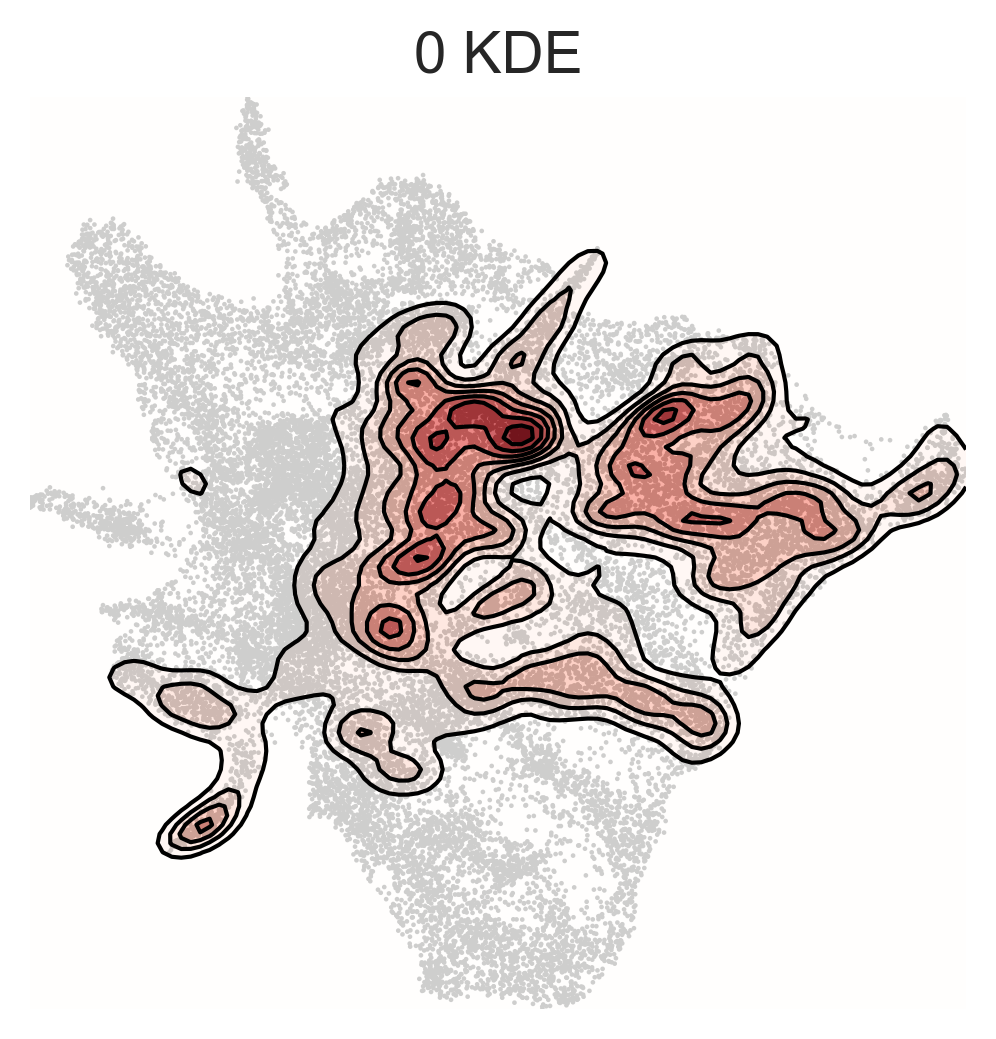

In [198]:
sl.pl.kde(adata_full, groupby="clones_clusters_0.5", group="0")

## Chondrocytes signature

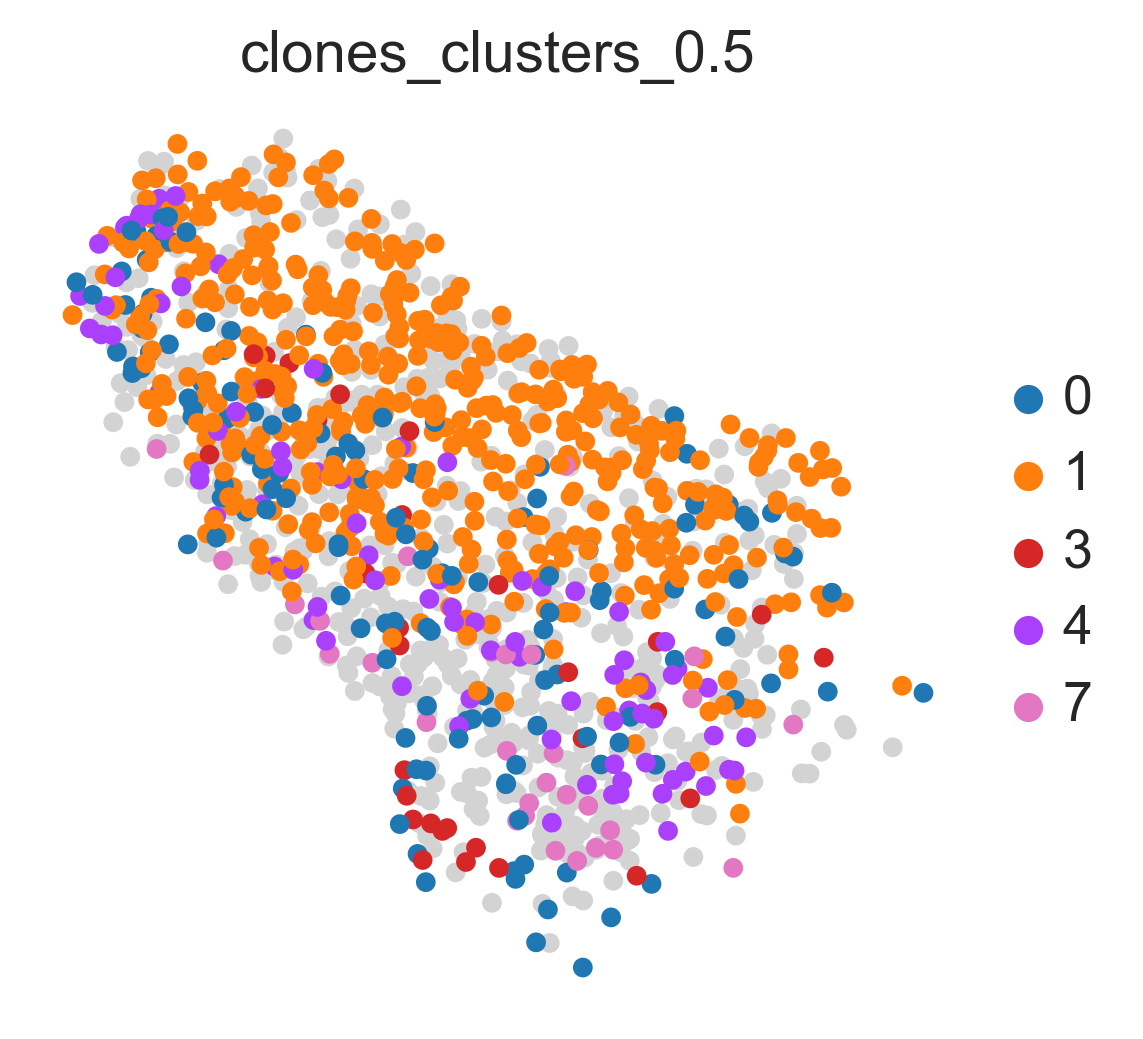

In [271]:
adata = adata_full[adata_full.obs.celltype_l2 == "Chondrocyte"]
whitelist = list(adata.obs["clones_clusters_0.5"].value_counts()[adata.obs["clones_clusters_0.5"].value_counts() > 10].index)
whitelist = np.array(whitelist)
whitelist = whitelist[~pd.Series(whitelist).isin(["NA", "8"])]
sc.pl.umap(adata, color="clones_clusters_0.5", frameon=False, groups=list(whitelist), na_in_legend=False)

In [273]:
adata_selected = adata[adata.obs["clones_clusters_0.5"].isin(whitelist)]
adata_selected.uns["log1p"]["base"] = np.e
sc.tl.rank_genes_groups(adata_selected, groupby="clones_clusters_0.5", method="t-test_overestim_var")
adata_selected.layers["scaled"] = sc.pp.scale(adata_selected.X, max_value=10, copy=True)

In [274]:
min_logfc = 1.5
max_pvalue = 1e-2
n_genes = 10

signatures = {}

for cluster in whitelist:
    df = sc.get.rank_genes_groups_df(adata_selected, group=cluster)
    signatures[cluster] = list(df[(df.pvals_adj <= max_pvalue) & (df.logfoldchanges >= min_logfc)].names[:n_genes])

In [275]:
signatures

{'1': ['Lama2',
  'Hpse2',
  'Alx1',
  'Pax3',
  'Igfbp5',
  'Spats2l',
  'P4ha3',
  'Tfap2b',
  'Tcea3',
  'Ccser1'],
 '0': ['Dlx5',
  'Dlx1as',
  'Tmtc2',
  'Pdzrn4',
  'Mab21l2',
  'Foxc2',
  'Dlx1',
  'Dlx6os1',
  'Rtl4',
  'Nnat'],
 '4': ['Mecom', 'Plcb1', 'Fibin', 'Prr16', 'Zfp503', 'Rps6ka6', 'Penk'],
 '3': ['Sfrp2', 'Id1', 'Tsc22d1', 'Meis2'],
 '7': ['Gpc3']}

In [276]:
for clonal_cluster in signatures:
    if len(signatures[clonal_cluster]) > 1:
        sc.tl.score_genes(adata_full, gene_list=signatures[clonal_cluster], score_name=f"clonal_signature_{clonal_cluster}")

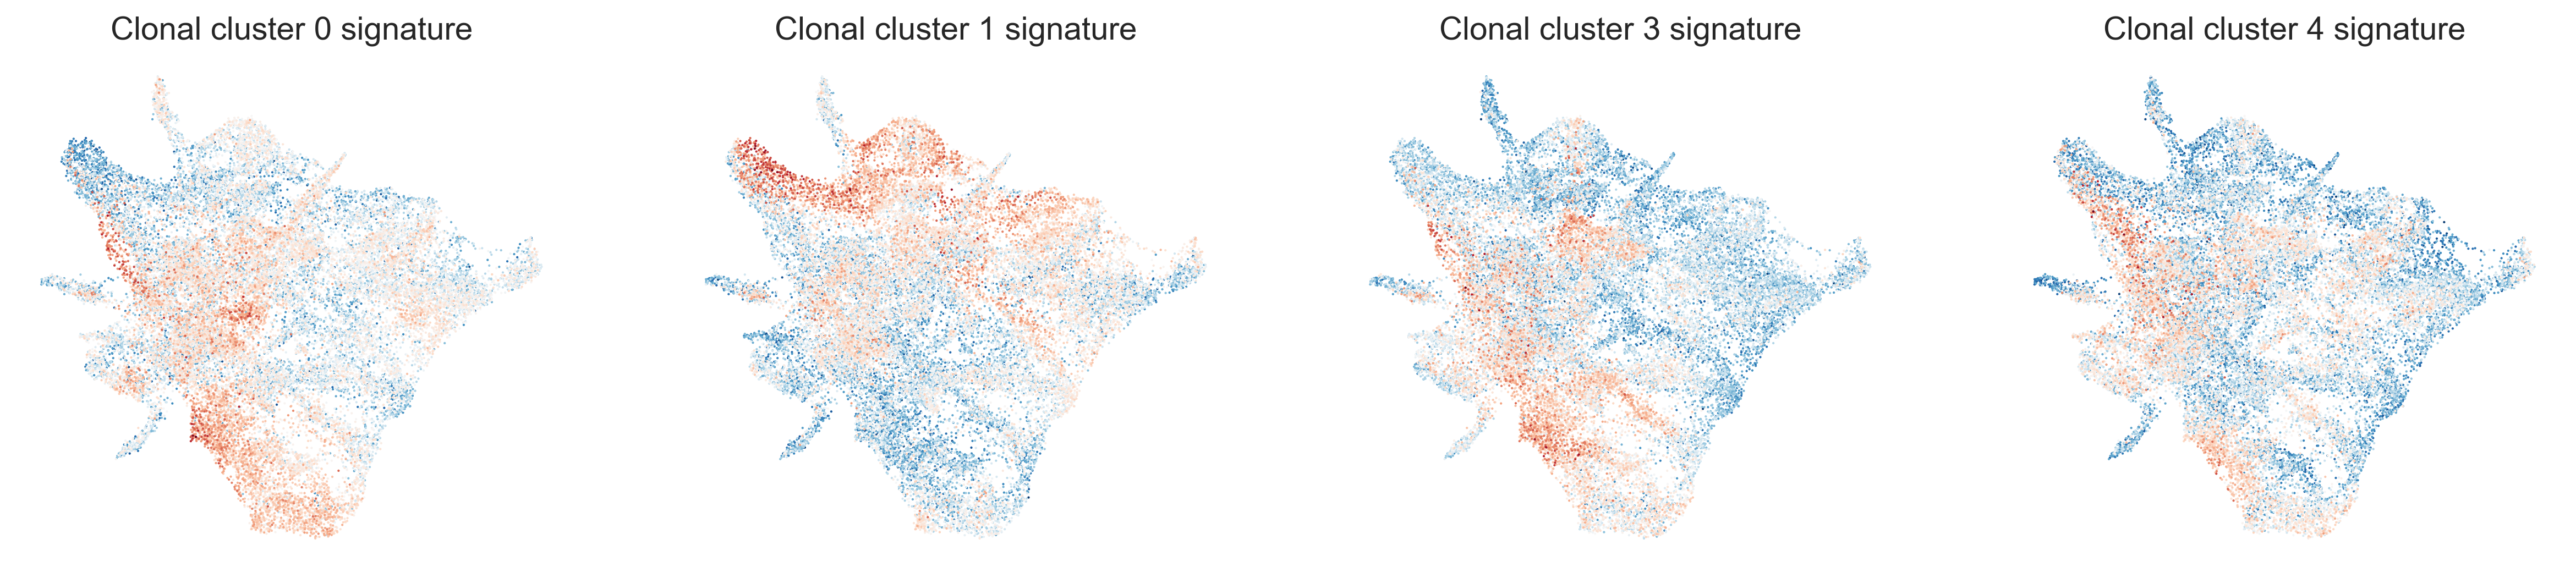

In [286]:
sc.pl.umap(
    adata_full,
    color=[
        "clonal_signature_0", "clonal_signature_1",
        "clonal_signature_3", "clonal_signature_4"
    ],
    cmap="RdBu_r",
    vcenter=0,
    frameon=False,
    title=[
        "Clonal cluster 0 signature", "Clonal cluster 1 signature",
        "Clonal cluster 3 signature", "Clonal cluster 4 signature"
    ],
    colorbar_loc=None,
)

         Falling back to preprocessing with `sc.pp.pca` and default params.


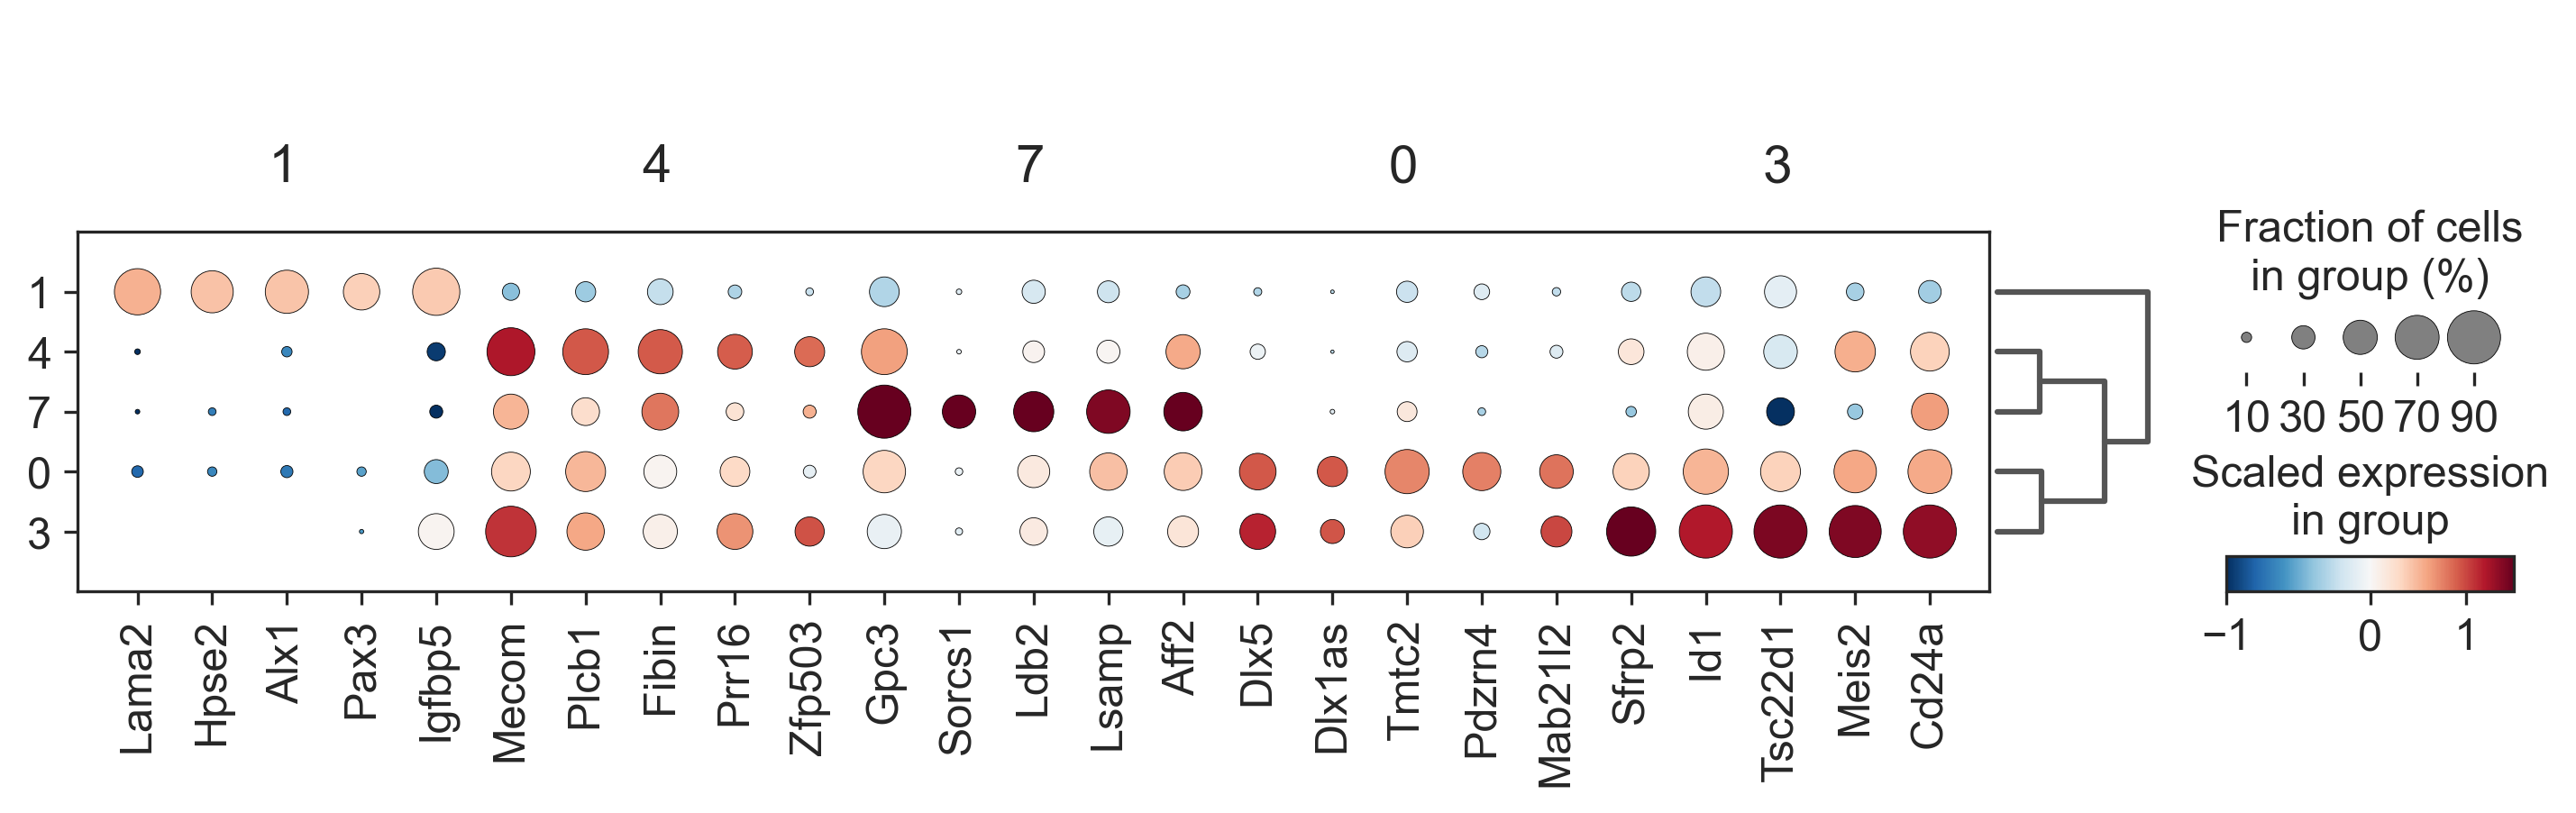

In [287]:
sc.pl.rank_genes_groups_dotplot(
    adata_selected,
    n_genes=5,
    dendrogram=True,
    layer="scaled",
    cmap="RdBu_r",
    vcenter=0,
    vmax=1.5,
    min_logfoldchange=1.5,
    vmin=-1,
    dot_max=0.9,
    colorbar_title="Scaled expression\nin group"
)